# Bike Sharing 

This notebook documents the analysis and model development for the Bike Sharing Dataset. It contains the following steps:

- About the Bike Sharing Dataset
- Descriptive Analysis
- Missing Value Analysis
- Outlier Analysis
- Correlation Analysis
- Overview metrics
- Model Selection
    -  Ridge Regession
    - Support Vector Regression
    - Essemble Regressor
    - Random Forest Regressor
- Random Forest
    - Random Forest Model
    - Feature importance
- Conclusion


## About the Bike Sharing Dataset

### Overview

In bike sharing systems, the entire process from membership to rental and return
has been automated. Using these systems, users can easily rent a bike from one
location and return it to another. Hence, a bike rental company wants to
understand and predict the number of bikes rented daily based on the
environment and seasons.

### Attribute Information

- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not 
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
    

- temp: Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

## Setup

In [3]:
pip install prettytable

Note: you may need to restart the kernel to use updated packages.


In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from prettytable import PrettyTable
import numpy as np
# Sklearn model delection
from sklearn.model_selection import RandomizedSearchCV
# Sklearn metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
# Sklearn models
from sklearn.linear_model import Lasso, ElasticNet, Ridge, SGDRegressor
from sklearn.svm import SVR, NuSVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LinearRegression

import random

%matplotlib inline

# Make results reproducible
random.seed(100)

In [3]:
import pandas as pd


class Dataloader(): 
    '''Bike Sharing Dataset dataloader.    
    '''

    def __init__(self, csv_path):
        ''' Initialize Bike Sharing Dataset dataloader.
        
        Arguments:
            csv_path {str} -- Path to the Bike Sharing Dataset CSV file.
        '''

        self.csv_path = csv_path
        self.data = pd.read_csv(self.csv_path)

        # Shuffle
        self.data.sample(frac=1.0, replace=True, random_state=1)

    def getHeader(self):
        ''' Get the column names of the Bike Sharing CSV file.
        
        Returns:
            [list of str] -- the column names of the csv file
        '''

        return list(self.data.columns.values)

    def getData(self):
        ''' Get the pandas frames for the training, validation and test split
        
        Returns:
            [pandas frames] -- the pandas frames for the different splits
        '''

        # Split data into train, validation and test set with 60:20:20 ratio
        split_train = int(60 / 100 * len(self.data)) 
        split_val = int(80 / 100 * len(self.data)) 
        train = self.data[:split_train]
        val = self.data[split_train:split_val]
        test = self.data[split_val:]
        return train, val,  test

    def getFullData(self):
        ''' Get all the data in one single pandas frame.
        
        Returns:
            [pandas frame] -- the complete Bike Sharing Dataset data
        '''

        return self.data

## Descriptive Analysis

Provide data set splits for training, validation, and testing:

In [46]:
dataloader = Dataloader(r"C:\Users\bhave\Downloads\bike_sharing.csv")
fullData = dataloader.getFullData()

category_features = ['season', 'holiday', 'mnth', 'yr', 'weekday', 'workingday', 'weathersit']
number_features = ['temp', 'atemp', 'hum', 'windspeed']

features= category_features + number_features
target = ['cnt']

In [33]:
list(fullData.columns)

['instant',
 'dteday',
 'season',
 'yr',
 'mnth',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'casual',
 'registered',
 'cnt']

In [30]:
fullData.head(2)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,02-01-2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801


Get data statistics for each column:

In [31]:
fullData[number_features].describe()

,temp,atemp,hum,windspeed
count,731.000000,731.000000,731.000000,731.000000
mean,0.495385,0.474354,0.627894,0.190486
std,0.183051,0.162961,0.142429,0.077498
min,0.059130,0.079070,0.000000,0.022392
25%,0.337083,0.337842,0.520000,0.134950
50%,0.498333,0.486733,0.626667,0.180975
75%,0.655417,0.608602,0.730209,0.233214
max,0.861667,0.840896,0.972500,0.507463


In [32]:
for col in category_features:
    fullData[col] = fullData[col].astype('category')
fullData[category_features].describe()

,season,holiday,mnth,yr,weekday,workingday,weathersit
count,731,731,731,731,731,731,731
unique,4,2,12,2,7,2,3
top,3,0,1,1,0,1,1
freq,188,710,62,366,105,500,463


## Missing Value Analysis

Check any NULL values in data:

In [14]:
print(fullData.isnull().any())

instant       False
dteday        False
season        False
yr            False
mnth          False
holiday       False
weekday       False
workingday    False
weathersit    False
temp          False
atemp         False
hum           False
windspeed     False
casual        False
registered    False
cnt           False
dtype: bool


## Outlier Analysis

### Box plots

[Text(0.5, 0, 'Temperature'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Temperature')]

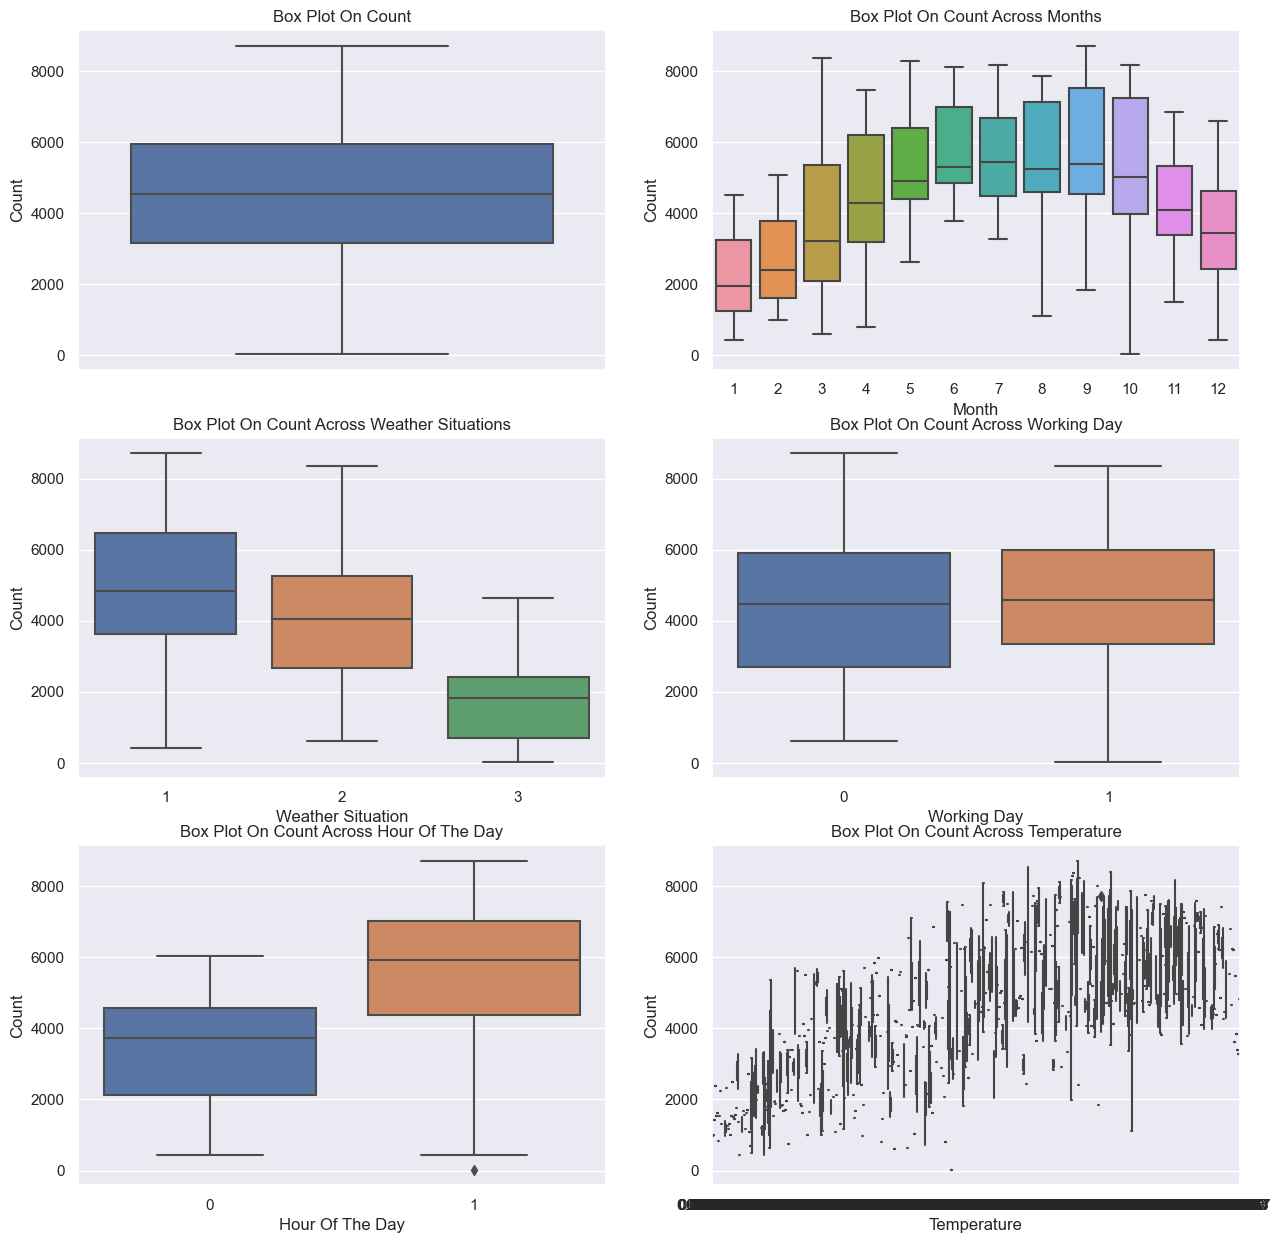

In [39]:
sns.set(font_scale=1.0)
fig, axes = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(15, 15)
sns.boxplot(data=fullData,y="cnt",orient="v",ax=axes[0][0])
sns.boxplot(data=fullData,y="cnt",x="mnth",orient="v",ax=axes[0][1])
sns.boxplot(data=fullData,y="cnt",x="weathersit",orient="v",ax=axes[1][0])
sns.boxplot(data=fullData,y="cnt",x="workingday",orient="v",ax=axes[1][1])
sns.boxplot(data=fullData,y="cnt",x="yr",orient="v",ax=axes[2][0])
sns.boxplot(data=fullData,y="cnt",x="temp",orient="v",ax=axes[2][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Month', ylabel='Count',title="Box Plot On Count Across Months")
axes[1][0].set(xlabel='Weather Situation', ylabel='Count',title="Box Plot On Count Across Weather Situations")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")
axes[2][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[2][1].set(xlabel='Temperature', ylabel='Count',title="Box Plot On Count Across Temperature")


### Remove outliers from data

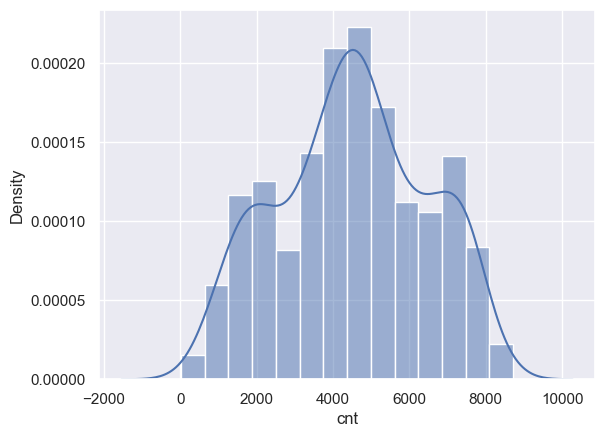

In [41]:
sns.histplot(fullData[target[-1]],kde= True , stat="density", kde_kws=dict(cut=3));

Samples in train set with outliers: 731
Samples in train set without outliers: 731


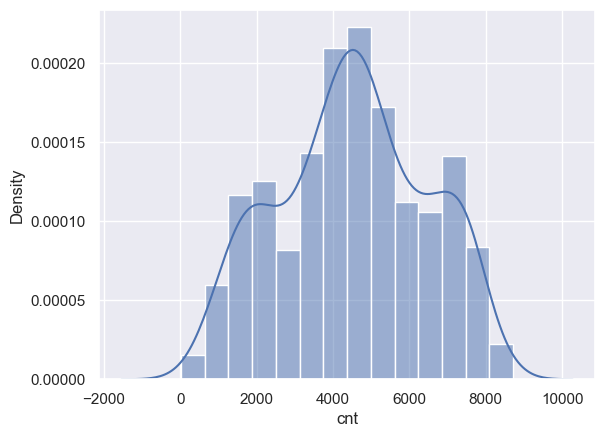

In [47]:
print("Samples in train set with outliers: {}".format(len(fullData)))
q1 = fullData.cnt.quantile(0.25)
q3 = fullData.cnt.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr) 
fullData_preprocessed = fullData.loc[(fullData.cnt >= lower_bound) & (fullData.cnt <= upper_bound)]
print("Samples in train set without outliers: {}".format(len(fullData_preprocessed)))
sns.histplot(fullData_preprocessed.cnt , kde = True , stat="density", kde_kws=dict(cut=3));

## Correlation Analysis

<Axes: >

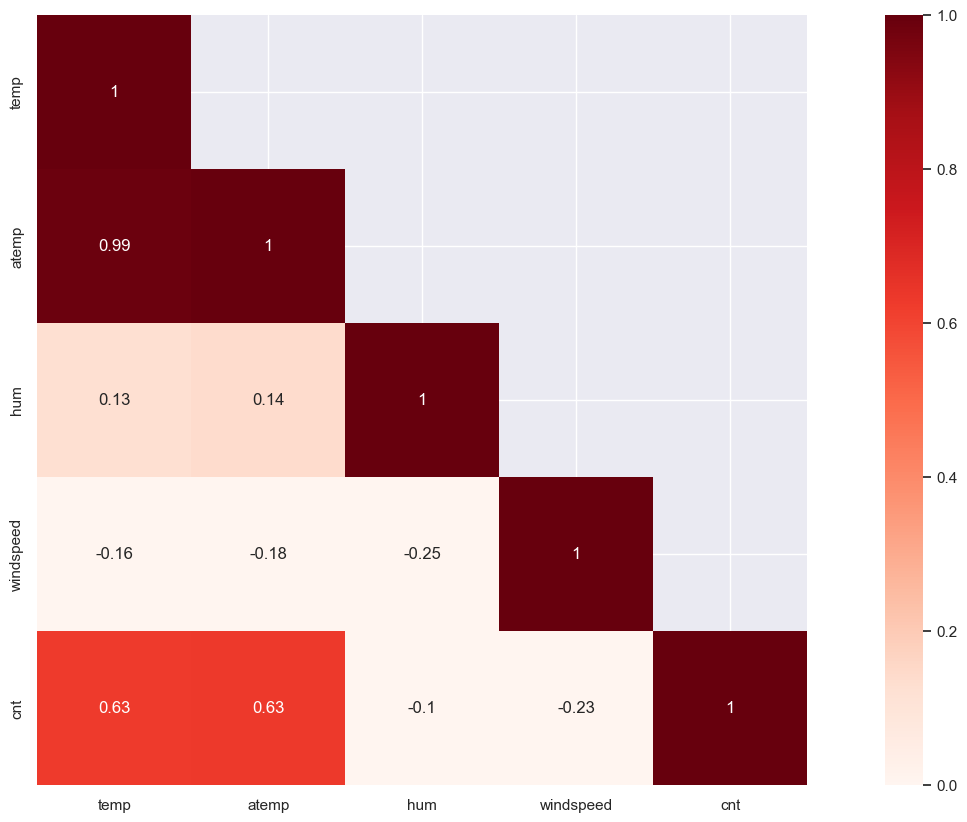

In [44]:
matrix = fullData[number_features + target].corr()
heat = np.array(matrix)
heat[np.tril_indices_from(heat)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.set(font_scale=1.0)
sns.heatmap(matrix, mask=heat,vmax=1.0, vmin=0.0, square=True,annot=True, cmap="Reds")

In [48]:
features.remove('atemp')

## Overview Metrics

### Mean Squared Error (MSE)

MSE = $\sqrt{\frac{1}{N} \sum_{i=1}^N (x_i - y_i)^2}$

### Root Mean Squared Logarithmic Error (RMSLE)

RMSLE = $\sqrt{ \frac{1}{N} \sum_{i=1}^N (\log(x_i) - \log(y_i))^2 }$

### $R^2$ Score

$R^2=1-\frac{\sum_{i=1}^{n}e_i^2}{\sum_{i=1}^{n}(y_i-\bar{y})^2}$

## Model Selection

In [58]:
# Split the dataset into train and test dataset
X = fullData.drop(columns=['dteday', 'cnt']) # Features
y = fullData['cnt'] # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Further split the training set into train and validation sets
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Normalize the features
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Create a model using the random forest algorithm
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_normalized, y_train)

# Predict the performance of the model on the test dataset
y_pred = rf_model.predict(X_test_normalized)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 10492.293673636374


The characteristics of the given problem are:

- __Regression:__ The target variable is a quantity.
- __Small dataset:__ Less than 100K samples.
- __Few features should be important:__ The correlation matrix indicates that a few features contain the information to predict the target variable.

This characteristic makes the following methods most promising: Ridge Regression, Support Vector Regression, Ensemble Regressor, Random Forest Regressor.

We will evaluate the performance of these models in the following:

In [59]:


table = PrettyTable()
table.field_names = ["Model", "Mean Squared Error", "R² score"]

models = [
    SGDRegressor(max_iter=1000, tol=1e-3),
    Lasso(alpha=0.1),
    ElasticNet(random_state=0),
    Ridge(alpha=.5),
    SVR(gamma='auto', kernel='linear'),
    SVR(gamma='auto', kernel='rbf'),
    BaggingRegressor(),
    BaggingRegressor(KNeighborsClassifier(), max_samples=0.5, max_features=0.5),
    NuSVR(gamma='auto'),
    RandomForestRegressor( random_state=42, n_estimators=300)
]

for model in models:
    model.fit(X_train, y_train) 
    y_res = model.predict(X_val)

    mse = mean_squared_error(y_val, y_res)
    score = model.score(X_val, y_val)    

    table.add_row([type(model).__name__, format(mse, '.2f'), format(score, '.2f')])

print(table)

+-----------------------+-------------------------------------+--------------------------------+
|         Model         |          Mean Squared Error         |            R² score            |
+-----------------------+-------------------------------------+--------------------------------+
|      SGDRegressor     | 67389888023473435679450850131968.00 | -17736653596152744787312640.00 |
|         Lasso         |                 0.00                |              1.00              |
|       ElasticNet      |                 0.00                |              1.00              |
|         Ridge         |                 0.00                |              1.00              |
|          SVR          |                 0.00                |              1.00              |
|          SVR          |              3830532.73             |             -0.01              |
|    BaggingRegressor   |               15752.36              |              1.00              |
|    BaggingRegressor   |     

## Random Forest

### Random Forest Model

In [61]:
# Table setup
table = PrettyTable()
table.field_names = ["Model", "Dataset", "MSE", "MAE", 'RMSLE', "R² score"]
# Model training
model = RandomForestRegressor(bootstrap=True, criterion='friedman_mse', max_depth=None,
           max_leaf_nodes=None,
           min_impurity_decrease=0.0, 
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
model.fit(X_train, y_train) 

def evaluate(x, y, dataset):
    pred = model.predict(x)

    mse = mean_squared_error(y, pred)
    mae = mean_absolute_error(y, pred)
    score = model.score(x, y)    
    rmsle = np.sqrt(mean_squared_log_error(y, pred))

    table.add_row([type(model).__name__, dataset, format(mse, '.2f'), format(mae, '.2f'), format(rmsle, '.2f'), format(score, '.2f')])
    

evaluate(X_train, y_train, 'training')
evaluate(X_test, y_test, 'test')

print(table)

+-----------------------+----------+----------+-------+-------+----------+
|         Model         | Dataset  |   MSE    |  MAE  | RMSLE | R² score |
+-----------------------+----------+----------+-------+-------+----------+
| RandomForestRegressor | training | 3266.86  | 36.55 |  0.02 |   1.00   |
| RandomForestRegressor |   test   | 10423.46 | 66.30 |  0.31 |   1.00   |
+-----------------------+----------+----------+-------+-------+----------+


### Feature importance

In [62]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

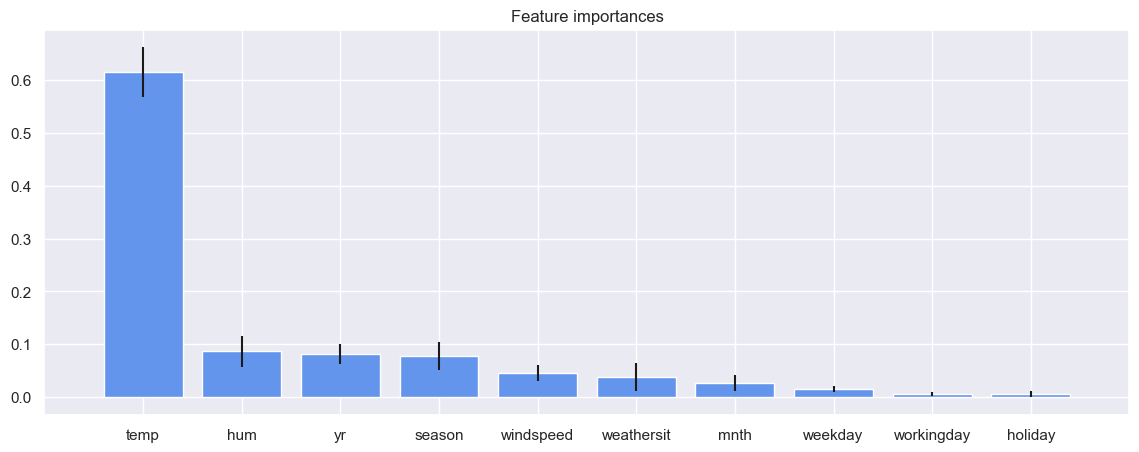

In [29]:
# Plot the feature importances of the forest
plt.figure(figsize=(14,5))
plt.title("Feature importances")
plt.bar(range(x_val.shape[1]), importances[indices], color="cornflowerblue", yerr=std[indices], align="center")
plt.xticks(range(x_val.shape[1]), [features[i] for i in indices])
plt.xlim([-1, x_val.shape[1]])
plt.show()